# **Spatial-Spectral Summarizer Fusion Network (S³F-Net) Baseline Implementation**

This notebook contains the full implementation of **Spatial CNN-based Baseline** on the HAM10000 (Skin Lesion Segmentation/Classification) dataset (This is the final implementation after the model/hyperparameter tuning was finalized. The tuning process was also carried out primarily using the original HAM10000 dataset), for comparisons with **S³F-Net**. Edit the file paths according to your setup.

## **Data Preparation**

In [ ]:
# ====================
# BLOCK 1: SETUP
# ====================

import os
import zipfile
from google.colab import drive

print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

# --- Defining Paths ---
ZIP_PATH = "/content/drive/MyDrive/Medical Image Segmentation/HAM10000.zip"
TEMP_DATA_DIR = "/content/ham10000_temp"

# --- Unzip the Data ---
if not os.path.exists(TEMP_DATA_DIR):
    print(f"\n--- Unzipping dataset to local runtime for fast access... ---")
    os.makedirs(TEMP_DATA_DIR, exist_ok=True)
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(TEMP_DATA_DIR)
        print("\n--- Unzipping complete! ---")
    except Exception as e:
        print(f"ERROR: Could not unzip file. Check ZIP_PATH. Error: {e}")
        exit()
else:
    print("\n--- Dataset already unzipped in this session. ---")

--- Mounting Google Drive ---
Mounted at /content/drive

--- Unzipping dataset to local runtime for fast access... ---

--- Unzipping complete! ---


In [ ]:
# ==============================================================================
# BLOCK 2: IMPORTS AND CONFIGURATION
# ==============================================================================
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
IMG_SIZE = (225, 300)
BATCH_SIZE = 16
EPOCHS = 200
RANDOM_STATE = 42

# --- Paths ---
DATASET_BASE_PATH = "/content/ham10000_temp/HAM10000"
SAVE_FOLDER = "/content/drive/MyDrive/S3F_Net_Models"
os.makedirs(SAVE_FOLDER, exist_ok=True)
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "Spatial_only_Baseline_HAM10000.keras")

In [ ]:
# ==========================
# BLOCK 3: DATA LOADING
# ==========================
def load_ham10000_split(base_path, csv_filename, image_foldername):
    """Loads a specific split (train or test) of the HAM10000 dataset."""
    csv_path = os.path.join(base_path, csv_filename)
    image_dir = os.path.join(base_path, image_foldername)
    df = pd.read_csv(csv_path)
    class_names = list(df.columns[1:])
    labels_one_hot = df.iloc[:, 1:].values
    labels_int = np.argmax(labels_one_hot, axis=1)
    images = []
    image_ids = df['image'].values
    print(f"Loading {len(image_ids)} images from: {image_dir}")
    for img_id in image_ids:
        img_path = os.path.join(image_dir, f"{img_id}.jpg")
        try:
            img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_AREA)
            img = img.astype('float32') / 255.0
            images.append(img)
        except Exception: continue
    return np.array(images), np.array(labels_int), class_names

try:
    # --- Loading the two separate datasets ---
    X_train, y_train, CLASS_NAMES = load_ham10000_split(DATASET_BASE_PATH, 'GroundTruth.csv', 'images')
    X_test, y_test, _ = load_ham10000_split(DATASET_BASE_PATH, 'Test_GroundTruth.csv', 'Test_images')   # The Test set is basically the Test set provided for ISIC Challenge 2018.

    print("\n--- Data Loading Summary ---")
    print(f"Training set:   {len(X_train)} samples")
    print(f"Test set:       {len(X_test)} samples")
    print(f"Class names:    {CLASS_NAMES}")

    # Calculating class weights from the training set
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))
    print(f"Calculated class weights: {class_weights_dict}")
    print("\nData is ready for model training.")

except Exception as e:
    print(f"An error occurred during data loading: {e}"); exit()

Loading 10015 images from: /content/ham10000_temp/HAM10000/images
Loading 1512 images from: /content/ham10000_temp/HAM10000/Test_images

--- Data Loading Summary ---
Training set:   10015 samples
Test set:       1512 samples (will be used for validation and final testing)
Class names:    ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
Calculated class weights: {0: np.float64(1.2854575792581184), 1: np.float64(0.21338020666879728), 2: np.float64(2.78349082823791), 3: np.float64(4.375273044997815), 4: np.float64(1.301832835044846), 5: np.float64(12.440993788819876), 6: np.float64(10.075452716297788)}

Data is ready for model training.


## **Spatial CNN Baseline Model Building**

In [ ]:
# ==============================================================================
# BLOCK 3: MODEL ARCHITECTURE (SPATIAL-ONLY Baseline FOR HAM10000)
# ==============================================================================
# This block defines the Spatial-Only baseline model, designed for a direct
# comparison with the S³F-Net architectures.

# --- Encoder Definition (Identical to the S³F-Net's spatial branch) ---
def build_spatial_encoder(inputs):
    x = inputs
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    return x

# --- Spatial-Only CNN Model Builder ---
def build_spatial_only_classifier(input_shape, num_classes):
    """Builds the classifier using only the spatial encoder and its head."""
    inputs = layers.Input(input_shape)

    # 1. Building Encoder
    features = build_spatial_encoder(inputs)

    # 2. Converting feature map to vector
    x = layers.GlobalAveragePooling2D()(features)

    # 3. Classifier Head (Matching the "Spatial Tower Head" from the S³F-Net)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # 4. Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="Spatial_Only_Classifier")

    # Compiling with the same optimizer and CE loss
    model.compile(optimizer=optimizers.Adam(0.0003),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("Spatial-Only model architecture definition is ready.")

Spatial-Only model architecture definition is ready.


## **Model Training**

In [ ]:
# ==============================================================================
# BLOCK 4: CUSTOM CALLBACK AND TRAINING (SPATIAL-ONLY BASELINE)
# ==============================================================================
from sklearn.metrics import f1_score

# --- Custom F1 Score Callback to use 'weighted' average ---
class F1ScoreCallback(callbacks.Callback):
    def __init__(self, validation_data, filepath, patience=25):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.filepath = filepath
        self.patience = patience
        self.best_f1 = -1.0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred_proba = self.model.predict(X_val, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Calculating the 'weighted' F1-score
        weighted_f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        logs['val_f1_weighted'] = weighted_f1

        print(f" - val_f1_weighted: {weighted_f1:.4f}", end="")

        if weighted_f1 > self.best_f1:
            print(f" (New best F1, saving model to {self.filepath})")
            self.best_f1 = weighted_f1
            self.model.save(self.filepath)
            self.wait = 0
        else:
            print()
            self.wait += 1
            if self.wait >= self.patience:
                print("Early stopping triggered based on weighted F1-score.")
                self.model.stop_training = True

# --- Defining the model path for this baseline experiment ---
CLASSIFIER_MODEL_PATH_BASELINE = os.path.join(SAVE_FOLDER, "Spatial_only_Baseline_HAM10000.keras")

# --- Building the Model ---
print("\n--- Building Spatial-Only Classifier ---")
classifier_model_baseline = build_spatial_only_classifier(X_train.shape[1:], num_classes=len(CLASS_NAMES))
classifier_model_baseline.summary()

# --- Define Callbacks ---
f1_callback_baseline = F1ScoreCallback(validation_data=(X_test, y_test),
                                       filepath=CLASSIFIER_MODEL_PATH_BASELINE,
                                       patience=40)

reduce_lr_baseline = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=20,
                                                 min_lr=1e-6,
                                                 verbose=1)

# --- Training the Model ---
print("\n--- Training Spatial-Only Baseline (Monitoring Weighted F1-Score) ---")
history_baseline = classifier_model_baseline.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[f1_callback_baseline, reduce_lr_baseline]
)

print("\n--- Training Finished ---")


--- Building Spatial-Only Classifier ---


Model: "Spatial_Only_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 225, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 225, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 225, 300, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 225, 300, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 225, 300, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 112, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 112, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 112, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 112, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 112, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 56, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 56, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 56, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 56, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 56, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 28, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 28, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 37, 256)    │             

 Total params: 1,311,399 (5.00 MB)

 Trainable params: 1,309,415 (5.00 MB)

 Non-trainable params: 1,984 (7.75 KB)


--- Training Spatial-Only Baseline (Monitoring Weighted F1-Score) ---
Epoch 1/200
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2785 - loss: 2.2640 - val_f1_weighted: 0.0405 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/spatial_only_HAM10000.keras)
626/626 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.2786 - loss: 2.2637 - val_accuracy: 0.1124 - val_loss: 2.6620 - val_f1_weighted: 0.0405 - learning_rate: 3.0000e-04
Epoch 2/200
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3193 - loss: 1.9830 - val_f1_weighted: 0.4382 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/spatial_only_HAM10000.keras)
626/626 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.3193 - loss: 1.9826 - val_accuracy: 0.3882 - val_loss: 1.6021 - val_f1_weighted: 0.4382 - learning_rate: 3.0000e-04
Epoch 3/200
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3736 - loss: 1.7444 - val_f1_weighted: 0.4646 (New best F1, saving model to /content/drive/My

## **Evaluation**



--- Final Evaluation of Spatial-Only Baseline on Unseen Test Set ---
Loading best model from: /content/drive/MyDrive/S2F_Net_Models/spatial_only_HAM10000.keras

--- Calculating Loss and Accuracy on Test Set ---
Test Loss:      0.9566
Test Accuracy:  0.6554
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step

--- Detailed Performance Metrics ---
Macro F1 Score:   0.5209
Weighted F1 Score:0.6780
Cohen's Kappa:    0.4824
MCC:              0.4912
AUC-ROC (Macro):  0.9095
AUC-ROC (Weighted):  0.8930

--- Classification Report ---
              precision    recall  f1-score   support

         MEL     0.3860    0.5146    0.4411       171
          NV     0.9112    0.7228    0.8061       909
         BCC     0.4711    0.6129    0.5327        93
       AKIEC     0.2717    0.5814    0.3704        43
         BKL     0.5109    0.5392    0.5247       217
          DF     0.3200    0.5455    0.4034        44
        VASC     0.5000    0.6571    0.5679        35

    accuracy                         0.6554  

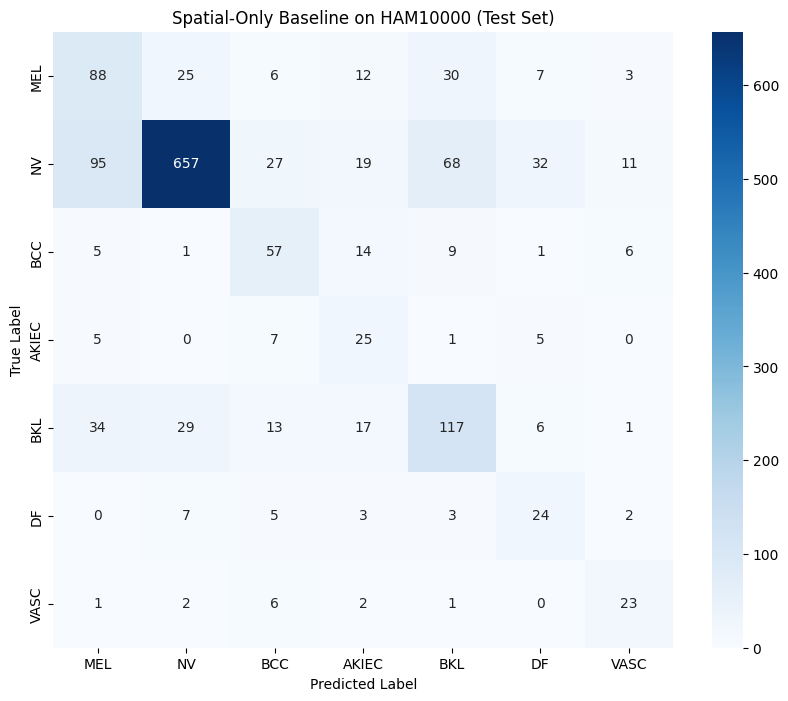


--- Training History Plots ---


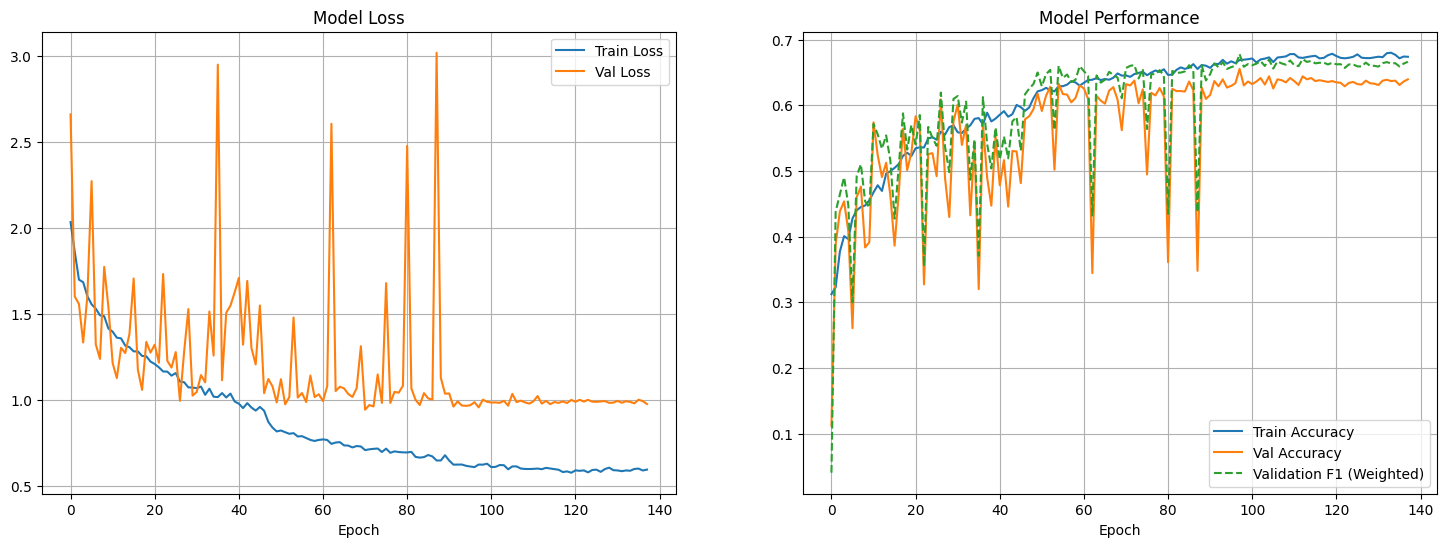


--- ROC Curve Analysis ---


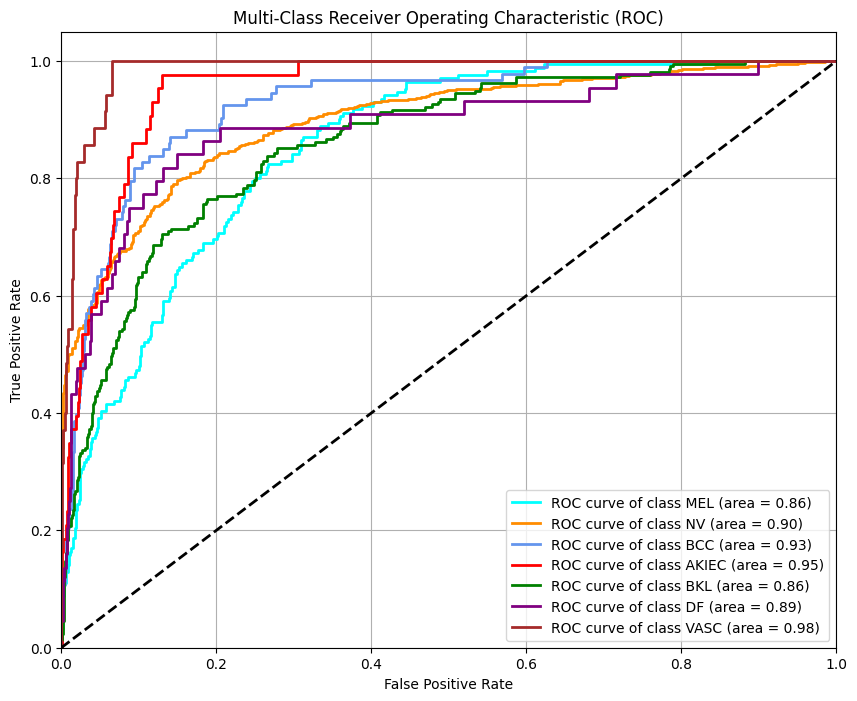


--- Script Finished ---


In [ ]:
# ======================
# BLOCK 5: EVALUATION
# ======================
print("\n\n--- Final Evaluation on HAM10000 dataset ---")

try:
    print(f"Loading best model from: {CLASSIFIER_MODEL_PATH_BASELINE}")
    best_model = models.load_model(CLASSIFIER_MODEL_PATH_BASELINE)

    # --- 1. Evaluating Loss and Accuracy ---
    print("\n--- Calculating Loss and Accuracy on Test Set ---")
    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss:      {loss:.4f}")
    print(f"Test Accuracy:  {accuracy:.4f}")

    # --- 2. Getting Predictions ---
    y_pred_proba = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    # --- 3. Detailed Metrics ---
    print("\n--- Detailed Performance Metrics ---")
    macro_f1 = f1_score(y_test, y_pred_classes, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    print(f"Macro F1 Score:   {macro_f1:.4f}")
    print(f"Weighted F1 Score:{weighted_f1:.4f}")

    kappa = cohen_kappa_score(y_test, y_pred_classes)
    mcc = matthews_corrcoef(y_test, y_pred_classes)
    print(f"Cohen's Kappa:    {kappa:.4f}")
    print(f"MCC:              {mcc:.4f}")

    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    weighted_auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    print(f"AUC-ROC (Macro):  {auc_roc:.4f}")
    print(f"AUC-ROC (Weighted):{weighted_auc_roc:.4f}")

    # --- 4. Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES, digits=4, zero_division=0))

    # --- 5. Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.title('Spatial-Only Baseline on HAM10000')
    plt.show()

    # --- 6. Plotting Training History ---
    if 'history_baseline' in locals() or 'history_baseline' in globals():
        print("\n--- Training History Plots ---")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        ax1.plot(history_baseline.history['loss'], label='Train Loss')
        ax1.plot(history_baseline.history['val_loss'], label='Val Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True)
        ax2.plot(history_baseline.history['accuracy'], label='Train Accuracy')
        ax2.plot(history_baseline.history['val_accuracy'], label='Val Accuracy')
        if 'val_f1_weighted' in history_baseline.history:
            ax2.plot(history_baseline.history['val_f1_weighted'], label='Validation F1 (Weighted)', linestyle='--')
        ax2.set_title('Model Performance')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True)
        plt.show()

    # --- 7. ROC Curve Plot ---
    print("\n--- ROC Curve Analysis ---")
    y_test_binarized = label_binarize(y_test, classes=range(len(CLASS_NAMES)))
    n_classes = y_test_binarized.shape[1]
    fpr, tpr, roc_auc_dict = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {CLASS_NAMES[i]} (area = {roc_auc_dict[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Multi-Class Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred during evaluation: {e}")

print("\n--- Script Finished ---")